In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import *
from imblearn.under_sampling import *
from imblearn.combine import SMOTEENN
from imblearn.base import BaseSampler

In [2]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [3]:
# os.chdir("/content/gdrive/Team Drives/AC211_final_project/")

In [4]:
monthly_murders = pd.read_csv("../data/final_monthlymurders.csv", index_col=0)
monthly_murders = monthly_murders.drop(columns=["MED_HH_ANN_INCOME"])
monthly_murders.head()

,GEOID,month,year,p_white,crime_count,counts_vandalism,counts_drug_crime,counts_agg_assaults,geometry
0,25025010405,7,2015,0.623088,0,38,16,21,"POLYGON ((-71.090087 42.346657, -71.0900049999..."
1,25025010405,8,2015,0.623088,0,38,16,21,"POLYGON ((-71.090087 42.346657, -71.0900049999..."
2,25025010405,9,2015,0.623088,0,38,16,21,"POLYGON ((-71.090087 42.346657, -71.0900049999..."
3,25025010405,10,2015,0.623088,0,38,16,21,"POLYGON ((-71.090087 42.346657, -71.0900049999..."
4,25025010405,11,2015,0.623088,0,38,16,21,"POLYGON ((-71.090087 42.346657, -71.0900049999..."


**Checking for correlations among relevant variables**

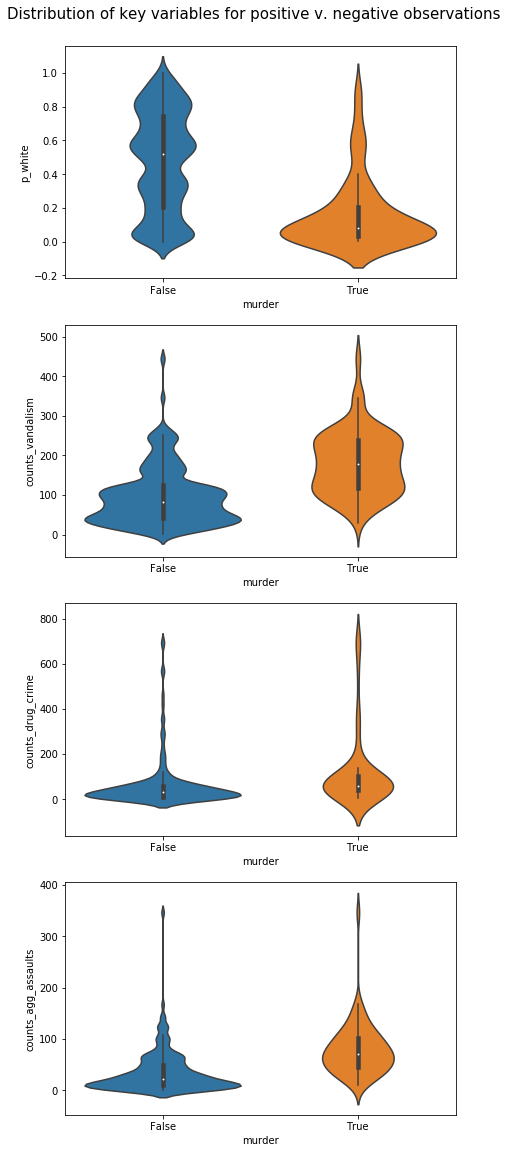

In [5]:
fig, axes = plt.subplots(nrows=4,ncols=1,figsize=(7,18))
axes = axes.ravel()

monthly_murders.loc[:,'murder'] = monthly_murders['crime_count'] > 0
predictors = ['counts_vandalism', 'counts_drug_crime', 'counts_agg_assaults']

for i, pred in enumerate(['p_white'] + predictors):
    sns.violinplot(x='murder', y=pred, data=monthly_murders, ax=axes[i])

plt.subplots_adjust(top=0.95)    
fig.suptitle("Distribution of key variables for positive v. negative observations", fontsize=15);

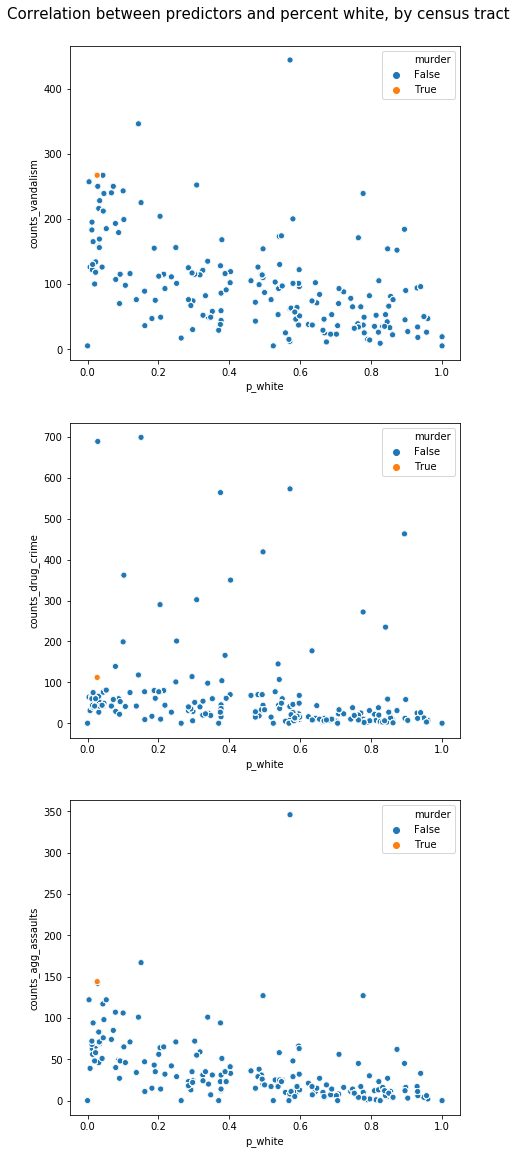

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7,18))
axes = axes.ravel()

for i, pred in enumerate(predictors):
    sns.scatterplot(x='p_white', y=pred, hue='murder', data=monthly_murders, ax=axes[i])

plt.subplots_adjust(top=0.95)    
fig.suptitle("Correlation between predictors and percent white, by census tract", fontsize=15);

**Split training and test sets**

In [7]:
# use the last year of data (04/01/2018 to 03/31/2019) as test set 
# --> test set includes ~30% (38/131) of all murders, and 26.7% (2136/8010)
#     of all observations

predictors = ["month"] + predictors

test_idxs = (monthly_murders['year']==2019) | \
            ((monthly_murders['year']==2018) & (monthly_murders['month']>3))

test_df = monthly_murders[test_idxs]
train_df = monthly_murders[~test_idxs]

y_train = (train_df.loc[:,'crime_count'] > 0).astype(int)
X_train = train_df.loc[:,predictors]

y_test = (test_df.loc[:,'crime_count'] > 0).astype(int)
X_test = test_df.loc[:,predictors]

In [8]:
# Baseline: breakdown of which tracts experienced 1+ murders, in train and
# test set, by type (true == high-minority)

mean_pwhite = monthly_murders[['GEOID','p_white']].drop_duplicates()['p_white'].mean()
print("Training set:")
print((train_df[train_df.murder][['GEOID','p_white']].drop_duplicates()['p_white'] < mean_pwhite).value_counts())
print("\nTest set:")
print((test_df[test_df.murder][['GEOID','p_white']].drop_duplicates()['p_white'] < mean_pwhite).value_counts())

Training set:
True     44
False     9
Name: p_white, dtype: int64

Test set:
True     24
False     3
Name: p_white, dtype: int64


**Prepare design matrix**

In [9]:
cat_cols = ["month"]
noncat_cols = [c for c in X_train.columns if c not in cat_cols]

# scale non-categorical features
scaler = StandardScaler().fit(X_train[noncat_cols].values)
scaled_cols = scaler.transform(X_train[noncat_cols].values)
X_train.loc[:,noncat_cols] = scaled_cols

scaled_cols = scaler.transform(X_test[noncat_cols].values)
X_test.loc[:,noncat_cols] = scaled_cols


# make categorical
X_train = pd.get_dummies(X_train, columns=cat_cols)
X_test = pd.get_dummies(X_test, columns=cat_cols)


# impute missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean').fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


**Run analysis**

In [10]:
# resampling techniques

class FakeSampler(BaseSampler):
    _sampling_type = 'bypass'
    def _fit_resample(self, X, y):
        return X, y

oversamples = [RandomOverSampler(), SMOTE(), ADASYN()]
oversample_names = ["Random oversampling", "SMOTE", "ADASYN"]
undersamples = [RandomUnderSampler(), ClusterCentroids(random_state=0), TomekLinks()]
undersample_names = ["Random undersampling", "Cluster centroids", "Tomek links"]
combined = [FakeSampler(), SMOTEENN()] + oversamples + undersamples
combined_names = ["No resampling", "SMOTE-EEN"] + oversample_names + undersample_names

In [11]:
# show impact of each rebalancing technique on data's distribution
def plot_class_distributions(X, x_var, y_var, x_label, y_label, title, legend, ax):
    X.groupby(y_var)[x_var].hist(ax=ax, alpha=0.5, histtype='step', bins=30, grid=False, linewidth=2, density=False)
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(legend, fontsize="x-large");

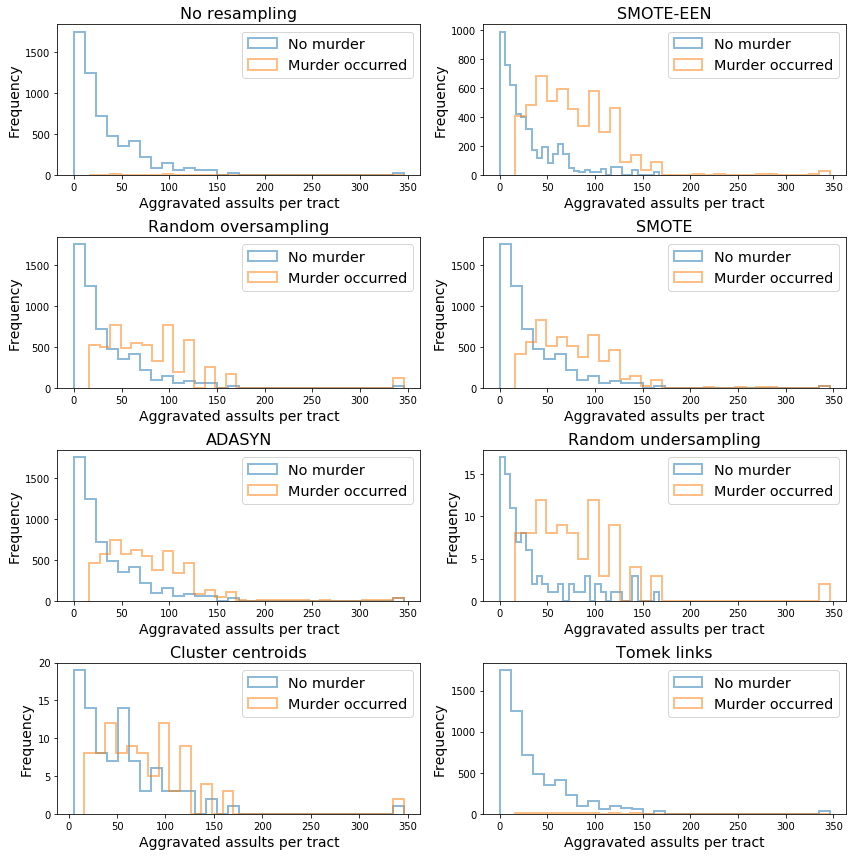

In [12]:
# from google.colab import files

fig, axes = plt.subplots(figsize=(12,12), nrows=4, ncols=2)
for i, (resample, resample_name) in enumerate(zip(combined, combined_names)):
    X_tr, y_tr = resample.fit_resample(X_train, y_train)

    X_tr = pd.DataFrame(scaler.inverse_transform(X_tr[:,:3]),
                        columns = ['counts_vandalism', 
                                   'counts_drug_crime', 
                                   'counts_agg_assaults'])

    resamp_df = X_tr.merge(pd.DataFrame(y_tr), left_index=True, right_index=True)
    resamp_df = resamp_df.rename(index=str, columns={0:'crime_count'})
    
    ix = np.unravel_index(i, axes.shape)
    plot_class_distributions(resamp_df, x_var='counts_agg_assaults', y_var='crime_count', 
                             x_label="Aggravated assults per tract", y_label="Frequency", 
                             title=resample_name, legend=('No murder','Murder occurred'), ax=axes[ix])

fig.tight_layout(w_pad=.93, h_pad=.9)
# plt.savefig("resampled_distributions.png")
# files.download("resampled_distributions.png") 

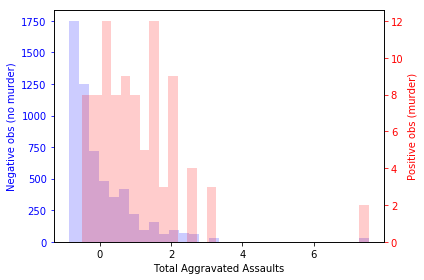

In [13]:

X_reconst = pd.DataFrame(X_train[:,:3], columns = ['counts_vandalism', 
                                                   'counts_drug_crime', 
                                                   'counts_agg_assaults']) 
y_reconst = pd.DataFrame(y_train)
reconst_df = pd.concat([X_reconst, y_reconst.reset_index()['crime_count']], 
                       ignore_index=True, axis=1)
reconst_df.columns = ['counts_vandalism', 'counts_drug_crime', 
                      'counts_agg_assaults', 'crime_count']

fig, ax1 = plt.subplots()
ax1.hist(reconst_df.loc[reconst_df['crime_count']==0,'counts_agg_assaults'], histtype='stepfilled', color='b', linewidth=2, alpha=0.2, bins=30)
ax1.set_xlabel('Total Aggravated Assaults')
ax1.set_ylabel('Negative obs (no murder)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.hist(reconst_df.loc[reconst_df['crime_count']==1,'counts_agg_assaults'], histtype='stepfilled', color='r', linewidth=2, alpha=0.2, bins=30)
ax2.set_ylabel('Positive obs (murder)', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()

In [14]:
def fit_return_preds_metrics(model, X_tr, y_tr, X_te, y_te, rebalance=None):
    if rebalance is not None:
        X_tr, y_tr = rebalance.fit_resample(X_tr, y_tr)
    
    mod = model.fit(X_tr, y_tr)
    preds = mod.predict(X_te)
    (tn, fp, fn, tp) = confusion_matrix(y_te, preds).ravel()
    
    return preds, (tn, fp, fn, tp)

In [15]:
#fit models after rebalancing in various ways
np.random.seed(221)
model_names = ["Nearest Neighbors", "Linear SVM", "Random Forest", "Neural Net"]
models = [KNeighborsClassifier(), 
          LinearSVC(max_iter=5000), 
          RandomForestClassifier(n_estimators=100), 
          MLPClassifier(max_iter=500, random_state=0, early_stopping=True)]


preds_df = test_df.copy()
results = {"Model":[], "Technique":[], "TN":[], "FP":[], "FN":[], "TP":[]}
for model, model_name in zip(models, model_names):
    for resample, resample_name in zip(combined, combined_names):
        preds, (tn, fp, fn, tp) = fit_return_preds_metrics(model, X_train, y_train, X_test, y_test, rebalance=resample)
        results["Model"].append(model_name)
        results["Technique"].append(resample_name)
        results["TN"].append(tn)
        results["FP"].append(fp)
        results["FN"].append(fn)
        results["TP"].append(tp)
        preds_df[model_name + " - " + resample_name] = preds
  
results_df = pd.DataFrame(results)
results_df['Total'] = results_df["TN"] + results_df["FP"] + results_df["FN"] + results_df["TP"]
results_df['Accuracy']  = (results_df["TN"] + results_df["TP"]) / results_df["Total"]
results_df['Precision'] = results_df["TP"] / (results_df["TP"] + results_df["FP"])
results_df['Recall']    = results_df["TP"] / (results_df["TP"] + results_df["FN"])
results_df['FP rate']   = results_df["FP"] / results_df["Total"]
results_df['FN rate']   = results_df["FN"] / results_df["Total"]




In [16]:
# performance metrics of different model-resampling technique combinations across all tracts
results_df.sort_values(by=['Technique','Model'])

,Model,Technique,TN,FP,FN,TP,Total,Accuracy,Precision,Recall,FP rate,FN rate
12,Linear SVM,ADASYN,1634,465,11,26,2136,0.777154,0.052953,0.702703,0.217697,0.005150
4,Nearest Neighbors,ADASYN,1987,112,30,7,2136,0.933521,0.058824,0.189189,0.052434,0.014045
28,Neural Net,ADASYN,1868,231,19,18,2136,0.882959,0.072289,0.486486,0.108146,0.008895
20,Random Forest,ADASYN,2088,11,37,0,2136,0.977528,0.000000,0.000000,0.005150,0.017322
14,Linear SVM,Cluster centroids,1658,441,10,27,2136,0.788858,0.057692,0.729730,0.206461,0.004682
6,Nearest Neighbors,Cluster centroids,1427,672,10,27,2136,0.680712,0.038627,0.729730,0.314607,0.004682
30,Neural Net,Cluster centroids,1280,819,4,33,2136,0.614700,0.038732,0.891892,0.383427,0.001873
22,Random Forest,Cluster centroids,1219,880,7,30,2136,0.584738,0.032967,0.810811,0.411985,0.003277
8,Linear SVM,No resampling,2099,0,37,0,2136,0.982678,NaN,0.000000,0.000000,0.017322
0,Nearest Neighbors,No resampling,2098,1,37,0,2136,0.982210,0.000000,0.000000,0.000468,0.017322


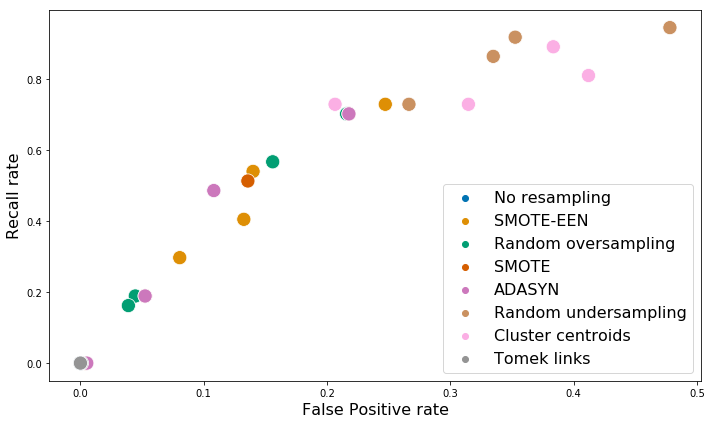

In [17]:
fsize = 16
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x='FP rate', y='Recall', hue='Technique', data=results_df, 
                ax=ax, s=200, palette="colorblind")
#ax.set_title("Tradeoff between recall and false positive rates", fontsize=16)
ax.set_ylabel("Recall rate", fontsize=fsize)
ax.set_xlabel("False Positive rate", fontsize=fsize)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], fontsize=fsize)
fig.tight_layout(w_pad=.93, h_pad=.9)
plt.savefig("fpr_recall_scatter.png")
# files.download("fpr_recall_scatter.png")


Observations:

•	**No resampling**: All four models perform equally poorly when the class imbalance goes untreated: they default to the "naive" approach of always predicting the majority class (no murders).

•	**Random oversampling**: the SVM and MLP are especially sensitive to oversampling, in that they predict many of the murders correctly, though also predict many murders that do not wind up occurring (i.e. have high false-positive rates). The amount of increase in models' recall (i.e. their ability to correctly predict the murders that do occur) corresponds directly with their increase in false positive rates.

•	**SMOTE**: the random forest model regressed to always predicting the absence of murder after applying SMOTE, the nearest-neighbors model achieved slightly improved recall without significant changes in the false positive rate relative to simple random oversampling, while the other two models performed marginally worse using SMOTE than with simple random oversampling.

•	**ADASYN**: the results were not substantially different for any of the models when using ADASYN than with SMOTE.

•	**SMOTE + EEN**: Combining SMOTE and EEN offered noticeable improvements in recall for all models except the MLP relative to SMOTE alone, though also increased the false positive rates, such that the overall precision did not dramatically change (with the exception of for the random forest model, which predicted a positive number of murders after introducing EEN).

•	**Random undersampling**: random undersampling caused comparably high overfitting for all four models, resulting in elevated recall rates in tandem with very high false positive rates. For the SVM, these results were comparable to those achieved using random oversampling, while the results were better using oversampling for the other three models. In fact, for the MLP, random undersampling causes a complete reversal in which the model always predicts that a murder will occur.  Random undersampling is therefore unambiguously inferior to random oversampling, as the lost information causes the models to mistake what were previously negative predictions instead as false positives.

•	**Tomek Links**: down-sampling using Tomek links was unsuccessful for all four models

•	**Cluster centroids**: replacing majority observations with representative examples yielded comparable results as using random undersampling


---


Model-wise conclusions:

*	All models always predicted no murders without resampling
*	The MLP predicted all murders after performing random undersampling
*	The random forest predicted no murders after performing SMOTE


In [18]:
def confidencemat_by_group(y_true, y_pred, majority):
    results = {}
    
    tn, fp, fn, tp = confusion_matrix(y_true[majority], y_pred[majority]).ravel()
    results['maj: TN'] = tn
    results['maj: FP'] = fp
    results['maj: FN'] = fn
    results['maj: TP'] = tp
    
    tn, fp, fn, tp = confusion_matrix(y_true[~majority], y_pred[~majority]).ravel()
    results['min: TN'] = tn
    results['min: FP'] = fp
    results['min: FN'] = fn
    results['min: TP'] = tp
    
    return results
    
    
# define "high-minority" tracts as those with a lower white share than the average tract
preds_df['high_minority'] = (preds_df['p_white'] < np.mean(monthly_murders['p_white'])).astype(np.bool)
preds_df['crime_occurred'] = preds_df['crime_count'].map({0:0, 1:1, 2:1})

confmatrices = {}
for variant in [col for col in preds_df.columns if ' - ' in col]:
    confmatrices[variant] = confidencemat_by_group(preds_df['crime_occurred'],
                                             preds_df[variant], 
                                             ~preds_df['high_minority'])

In [19]:
preds_df.groupby(['crime_occurred','high_minority']).size().reset_index()

,crime_occurred,high_minority,0
0,0,False,1185
1,0,True,914
2,1,False,3
3,1,True,34


Of the 37 tracts in which a murder occurred over the past year, 34 were high-minority. So, 34/948 (3.59%) of high-minority tracts witnessed a murder during that period, while only 3/1188 (0.253%) of low-minority tracts did.

In [20]:
confmatrices_df = pd.DataFrame(confmatrices).transpose().reset_index()
confmatrices_df['Algorithm'], confmatrices_df['Resampling Method'] = confmatrices_df['index'].str.split(' - ', 1).str
confmatrices_df = confmatrices_df[list(confmatrices_df.columns[-2:]) + list(confmatrices_df.columns[1:-2])]
confmatrices_df.sort_values(['Resampling Method', 'Algorithm'])

,Algorithm,Resampling Method,maj: FN,maj: FP,maj: TN,maj: TP,min: FN,min: FP,min: TN,min: TP
12,Linear SVM,ADASYN,3,108,1077,0,8,357,557,26
4,Nearest Neighbors,ADASYN,3,16,1169,0,27,96,818,7
28,Neural Net,ADASYN,2,48,1137,1,17,183,731,17
20,Random Forest,ADASYN,3,0,1185,0,34,11,903,0
14,Linear SVM,Cluster centroids,2,126,1059,1,8,315,599,26
6,Nearest Neighbors,Cluster centroids,0,259,926,3,10,413,501,24
30,Neural Net,Cluster centroids,0,271,914,3,4,548,366,30
22,Random Forest,Cluster centroids,3,271,914,0,4,609,305,30
8,Linear SVM,No resampling,3,0,1185,0,34,0,914,0
0,Nearest Neighbors,No resampling,3,0,1185,0,34,1,913,0


In [21]:
fairness_df = confmatrices_df[['Resampling Method','Algorithm']].copy()
maj_total = confmatrices_df.apply(lambda x: x["maj: FN"] + x["maj: FP"] + x["maj: TN"] + x["maj: TP"], axis=1)
min_total = confmatrices_df.apply(lambda x: x["min: FN"] + x["min: FP"] + x["min: TN"] + x["min: TP"], axis=1)
assert((maj_total.nunique()==1) & (min_total.nunique()==1))

# fairness_df["Predictive parity"] = confmatrices_df.apply(
#     lambda x: "TP rate: maj={:.2f}, min={:.2f}".format(x["maj: TP"]/maj_total[0], 
#                                                        x["min: TP"]/min_total[0]), axis=1)

# fairness_df["Predictive equity"] = confmatrices_df.apply(
#     lambda x: "FP rate: maj={:.2f}, min={:.2f}".format(x["maj: FP"]/maj_total[0], 
#                                                        x["min: FP"]/min_total[0]), axis=1)

fairness_df["Precision"] = confmatrices_df.apply(
    lambda x: "maj={:.2f}, min={:.2f}".format(x["maj: TP"]/(x["maj: TP"] + x["maj: FP"] + 1e-8),
                                              x["min: TP"]/(x["min: TP"] + x["min: FP"] + 1e-8)), axis=1)

fairness_df["Recall"] = confmatrices_df.apply(
    lambda x: "maj={:.2f}, min={:.2f}".format(x["maj: TP"]/(x["maj: TP"] + x["maj: FN"] + 1e-8),
                                              x["min: TP"]/(x["min: TP"] + x["min: FN"] + 1e-8)), axis=1)

fairness_df["Accuracy"] = confmatrices_df.apply(
    lambda x: "maj={:.2f}, min={:.2f}".format((x["maj: TP"]+x["maj: TN"])/(maj_total[0] + 1e-8),
                                              (x["min: TP"]+x["min: TN"])/(min_total[0] + 1e-8)), axis=1)

fairness_df["minority excess TP rate (predictive parity)"] = confmatrices_df.apply(
    lambda x: (x["min: TP"]/min_total[0]) - (x["maj: TP"]/maj_total[0]), axis=1)


fairness_df["minority excess FP rate (predictive equity)"] = confmatrices_df.apply(
    lambda x: (x["min: FP"]/min_total[0]) - (x["maj: FP"]/maj_total[0]), axis=1)

fairness_df.sort_values(["Algorithm", "Resampling Method"])

,Resampling Method,Algorithm,Precision,Recall,Accuracy,minority excess TP rate (predictive parity),minority excess FP rate (predictive equity)
12,ADASYN,Linear SVM,"maj=0.00, min=0.07","maj=0.00, min=0.76","maj=0.91, min=0.61",0.027426,0.285673
14,Cluster centroids,Linear SVM,"maj=0.01, min=0.08","maj=0.33, min=0.76","maj=0.89, min=0.66",0.026584,0.226218
8,No resampling,Linear SVM,"maj=0.00, min=0.00","maj=0.00, min=0.00","maj=1.00, min=0.96",0.000000,0.000000
10,Random oversampling,Linear SVM,"maj=0.00, min=0.07","maj=0.00, min=0.76","maj=0.92, min=0.61",0.027426,0.302316
13,Random undersampling,Linear SVM,"maj=0.00, min=0.06","maj=0.00, min=0.79","maj=0.89, min=0.53",0.028481,0.351756
11,SMOTE,Linear SVM,"maj=0.00, min=0.07","maj=0.00, min=0.76","maj=0.91, min=0.61",0.027426,0.285673
9,SMOTE-EEN,Linear SVM,"maj=0.00, min=0.06","maj=0.00, min=0.79","maj=0.89, min=0.56",0.028481,0.325576
15,Tomek links,Linear SVM,"maj=0.00, min=0.00","maj=0.00, min=0.00","maj=1.00, min=0.96",0.000000,0.000000
4,ADASYN,Nearest Neighbors,"maj=0.00, min=0.07","maj=0.00, min=0.21","maj=0.98, min=0.87",0.007384,0.087798
6,Cluster centroids,Nearest Neighbors,"maj=0.01, min=0.05","maj=1.00, min=0.71","maj=0.78, min=0.55",0.022791,0.217641


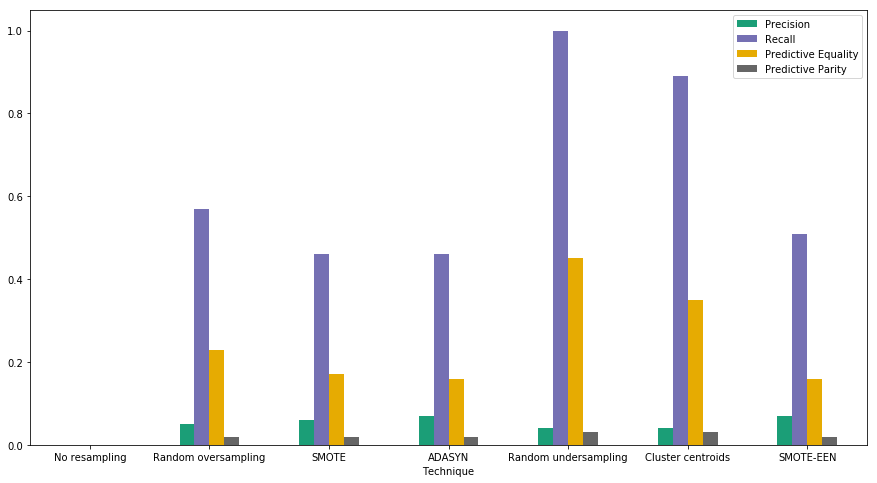

In [22]:
fig, ax = plt.subplots(figsize=(15,8))
nn_results = pd.read_csv("../data/nn_results.csv")
nn_results = nn_results.set_index(nn_results.Technique)
nn_results.plot(kind='bar', colormap='Dark2', ax=ax, rot=0);
# plt.savefig("grouped_bar.png")
# files.download("grouped_bar.png")

---